## Boston Marathon Cluster Challenge
__July, 2018 - Christopher Sanchez__

We will be examining some data about the Boston Marathon. We are going to try to cluster the data, and determine the best cluster type, and the amount of clusters. We will also see what we can learn from the data. The data can be found at the following link: https://github.com/llimllib/bostonmarathon

Let's begin!

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from sklearn import metrics, preprocessing
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
%matplotlib notebook


Let's import our data, and create a copy to allow us to look back at our original data after it has been processed. We'll also display the shape and head of the data.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2013/results.csv')
df_copy = df.copy()

print(df.head())
print(df.shape)

     25k  age               name  division    10k gender   half  official bib  ctz country  overall  pace state    30k     5k  genderdiv    20k     35k      city     40k
0  49.87   28   Cassidy, Josh R.         9  18.18      M  40.93     90.90  W1  NaN     CAN        9  3.47    ON  62.07   8.90          9  38.80   74.73   Toronto   85.55
1  77.27   30      Korir, Wesley         5  30.90      M  64.90    132.50   1  NaN     KEN        5  5.07   NaN  92.97  15.90          5  61.52  108.78     Kenya  124.77
2  77.23   23     Desisa, Lelisa         1  30.90      M  64.92    130.37   2  NaN     ETH        1  4.98   NaN  92.72  15.93          1  61.53  108.68      Ambo  123.78
3  50.50   32  Fearnley, Kurt H.         5  18.73      M  42.00     88.43  W2  NaN     AUS        5  3.38   NaN  61.35   8.98          5  39.88   73.00  Hamilton   83.43
4  48.75   39     Hokinoue, Kota         3  18.18      M  40.57     87.22  W3  NaN     JPN        3  3.33   NaN  59.92   8.92          3  38.55   71.6

It's looking good. The first things to notice are the features that contain strings, and the NaN values. We will handle the strings later on, but for now let's take a look at the missing values.

In [3]:
pd.isnull(df).sum()

25k              0
age              0
name             0
division         0
10k              0
gender           0
half             0
official         0
bib              0
ctz          15407
country          0
overall          0
pace             0
state         1463
30k              0
5k               0
genderdiv        0
20k              0
35k              0
city             1
40k              0
dtype: int64

Ok great, the only missing values are strings, so they won't be necessary, lets go ahead and process the data now.

In [4]:
# dropping values with strings and converting our gender feature to binary values.
df.drop(['name', 'bib', 'country', 'genderdiv', 'division', 'ctz', 'state', 'city'], axis=1, inplace = True)
df['gender'] = df['gender'].replace('M', 0)
df['gender'] = df['gender'].replace('F', 1)

# name our columns, so we don't lose the names after we process the dataframe.
columns = ['25k', 'age', '10k', 'gender', 'half', 'official', 'overall', 'pace', '30k', '5k', '20k', '35k', '40k']

# convert the dataframe to numeric, drop the missing values and normalize the data.
df = df.apply(pd.to_numeric, errors = 'coerce')
df = df.dropna()
df = preprocessing.normalize(df)
df = pd.DataFrame(df, columns=columns)

# Create our pca for visualization
X_pca = PCA(2).fit_transform(df)


Now that we've accomplished that lets take a deeper dive into the data. We'll start by examining our correlated features.

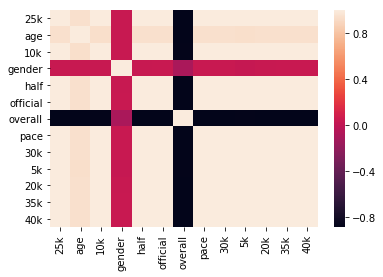

In [5]:
corr = df.corr()
sns.heatmap(corr)

It seems most of our features are correlated, besides gender. How a runner does on one run directly correlates how he did on another. It also effects the pace and overall.

Let's take a look at our age distribution:

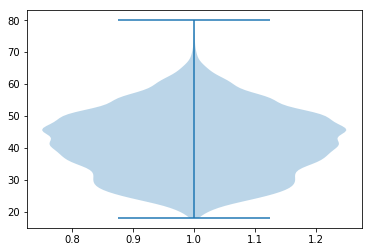

In [6]:
plt.violinplot(df_copy['age']);

It looks like our widest range of runners are in their 40's. It is impressive to see people still participating after they're 70 years old.

How many of our runners are male and how many are female?

M    9680
F    6484
Name: gender, dtype: int64


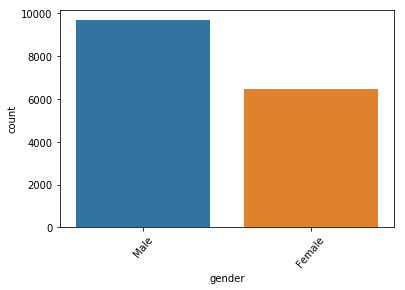

In [7]:
xticklabels = ['Male', 'Female']
g = sns.countplot(df_copy['gender']);
g.set_xticklabels(xticklabels, rotation=50);
print(df_copy.gender.value_counts())

There is over 30% more male runners than female runners.

How does age effect run times?

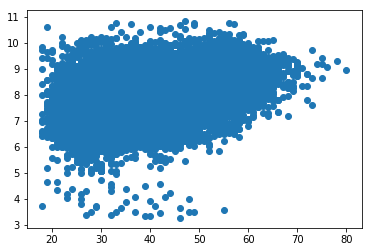

In [8]:
plt.scatter(df_copy['age'], df_copy['pace']);

It looks like younger runners have a higher pace than the older runners, however there are some older runner outliers.

We now know that there is a diverse range of ages, more male runners, and age does effect pace. We also know that most of our variables are correlated amongst each other. Now lets get to clustering. We will start by figuring out our best K Means model. We will experiment with different sized clusters, and determine the best cluster with a silhouette score.

## KMeans

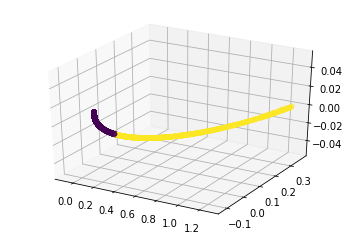

0.9398291180964314


In [9]:

# Calculate predicted values.
km = KMeans(n_clusters=2, random_state=42).fit(df)
km_labels = km.labels_

df['KMeansLabels'] = pd.Series(km_labels, index=df.index)
# Plot the solution.
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1],c=km_labels)
plt.show()

from sklearn import metrics
    
#metrics.adjusted_rand_score(y, y_pred)

print(metrics.silhouette_score(df, km_labels, metric='euclidean'))

After some number of cluster adjustments we were able to determine that 2 clusters is the best and we were able to get a silhouette score of 94% meaning our clustering algorithm was very good at separating our clusters. How did it separate the clusters though? Let's take a look.

In [10]:
group_by_kmeans = df.groupby('KMeansLabels').mean()
group_by_kmeans.head()

,25k,age,10k,gender,half,official,overall,pace,30k,5k,20k,35k,40k
KMeansLabels,,,,,,,,,,,,,
0,0.022340,0.007869,0.008874,0.000048,0.018790,0.038994,0.994144,0.001489,0.027056,0.004452,0.017814,0.031928,0.036838
1,0.219343,0.081951,0.086813,0.000069,0.184619,0.380447,0.566205,0.014530,0.265437,0.043380,0.175115,0.312693,0.359279


After reviewing the clusters of our KMeans model we can learn quite a bit of valuable information.

Group 0:
- Has the fastest run times, lowest age, highest overall, fastest pace. So from this cluster it appears that younger people and males are the fastest.

Group 1:
- Is full of the slower runners. It has the slowest run times, a higher age, a higher percentage of females a lower overall score, and a slower pace. 

Now let's see if we can do better with a different algorithm. We will try MeanShift. It is important to note that Mean Shift determines its own clusters.

## MeanShift

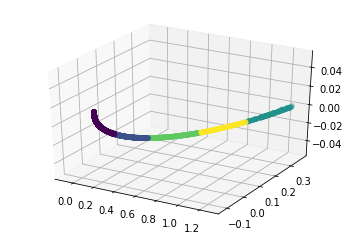

Number of estimated clusters: 5
Comparing the assigned categories to the ones in the data:
Silhouette score: 0.9549608938217509


In [11]:

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(df, quantile=0.4, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms = ms.fit(df)

# Extract cluster assignments for each data point.
ms_labels = ms.labels_
df['MeanShiftLabels'] = pd.Series(ms_labels, index=df.index)
# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(ms_labels))


fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1],c=ms_labels)
plt.show()
print("Number of estimated clusters: {}".format(n_clusters_))
print('Comparing the assigned categories to the ones in the data:')
print('Silhouette score:', metrics.silhouette_score(df, ms_labels, metric='euclidean'))


In [12]:
group_by_meanshift = df.groupby('MeanShiftLabels').mean()
group_by_meanshift.head()

,25k,age,10k,gender,half,official,overall,pace,30k,5k,20k,35k,40k,KMeansLabels
MeanShiftLabels,,,,,,,,,,,,,,
0,0.022340,0.007869,0.008874,0.000048,0.018790,0.038994,0.994144,0.001489,0.027056,0.004452,0.017814,0.031928,0.036838,0
1,0.167232,0.058084,0.066548,0.000023,0.140895,0.289018,0.814843,0.011037,0.201934,0.033361,0.133602,0.237382,0.273145,1
2,0.284196,0.129270,0.110256,0.000307,0.238185,0.499790,0.108465,0.019089,0.346665,0.054655,0.226062,0.411443,0.471094,1
3,0.228860,0.079113,0.091372,0.000000,0.193028,0.394294,0.613029,0.015060,0.276097,0.045824,0.183077,0.324226,0.372706,1
4,0.270408,0.093414,0.107627,0.000000,0.227895,0.467365,0.363714,0.017850,0.326254,0.053766,0.216114,0.383408,0.441340,1


Our Mean Shift algorithm performed even better than our K means model producing a silhouette score of 95%. Instead of 2 clusters it used 5.

After reviewing our clusters we can determine that:

Cluster 0 consists of the fastest runners, the highest overall and the fastest pace.

Cluster 1 is a little bit slower than cluster 0, but similar.

Cluster 2 is our slowest runners, having the lowest run times, overall, and pace.

Cluster 3 is in the middle of clusters 1 and 2

Cluster 4 is slightly faster that cluster 2, but slower than cluster 3.

As you can see this modeling method separates it in similar, but different ways. It seems to have classified the groups into several clusters based on their speed, rather than just 2 like our K means (slow and fast).

## Discussion and Conclusion

We were able to successfully cluster our data utilizing two different models, K means and Mean Shift to a high degree of accuracy. Though Mean Shift performed slightly better than K means I think I would stick with K means due to its simplicity and it being less resource expensive. We were able to determine that age has an effect on run times and pace, there is a large variation of ages, genders and run times. 